In [291]:
import os
import re
import _pickle as cPickle
from collections import OrderedDict, defaultdict, Counter

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

from data_structure import Instance

# configure

In [196]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('train_path', 'data/apnews/apnews50k_train.txt', 'path of output data')
flags.DEFINE_string('valid_path', 'data/apnews/apnews50k_valid.txt', 'path of input data')
flags.DEFINE_string('test_path', 'data/apnews/apnews50k_test.txt', 'path of input data')

flags.DEFINE_string('stopwords_path', 'data/stopwords_mallet.txt', 'path of input data')

flags.DEFINE_string('output_path', 'data/apnews/instances.pkl', 'path of output data')

flags.DEFINE_integer('n_vocab', 50000, 'size of vocab')

flags.DEFINE_string('f', '', 'kernel')

config = flags.FLAGS

In [262]:
# special tokens
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences
dummy_tokens = [PAD, UNK, BOS, EOS]

# load source

In [277]:
def get_df(data_path):
    data_dict = defaultdict(list)
    with open(data_path, 'r') as f:
        txt = f.readlines()
        for doc in txt:
            doc = re.sub(r'-', ' ', doc)
            doc = re.sub(r'[0-9]+.[0-9]+|[0-9]+,[0-9]+|[0-9]+', '<num>', doc)
            lines = doc.split('\t')
            doc = ' '.join(lines)
            data_dict['doc'].append(doc)
            tokens = [word_tokenize(line)[:-1] for line in lines]
            data_dict['tokens'].append(tokens)
            data_dict['doc_l'].append(len(tokens))
            data_dict['max_sent_l'].append(max([len(line) for line in tokens]))
    data_df = pd.DataFrame(data_dict)
    return data_df

In [282]:
raw_train_df = get_df(config.train_path)
raw_valid_df = get_df(config.valid_path)
raw_test_df = get_df(config.test_path)

In [460]:
# train_df = raw_train_df[(raw_train_df['doc_l'] <= 20) & (raw_train_df['max_sent_l'] <= 60)]
# valid_df = raw_valid_df[(raw_valid_df['doc_l'] <= 40) & (raw_valid_df['max_sent_l'] <= 60)]
# test_df = raw_test_df[(raw_test_df['doc_l'] <= 40) & (raw_test_df['max_sent_l'] <= 60)]

train_df = raw_train_df[(raw_train_df['doc_l'] <= 10) & (raw_train_df['max_sent_l'] <= 40)]
valid_df = raw_valid_df[(raw_valid_df['doc_l'] <= 10) & (raw_valid_df['max_sent_l'] <= 40)]
test_df = raw_test_df[(raw_test_df['doc_l'] <= 10) & (raw_test_df['max_sent_l'] <= 40)]

In [462]:
len(train_df), len(valid_df), len(test_df)

(26828, 1025, 1078)

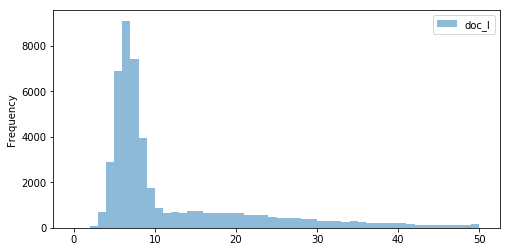

In [463]:
raw_train_df.plot(y=['doc_l'], bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 50));

In [464]:
np.sum(raw_train_df['doc_l'] <= 20) / len(raw_train_df)

0.80902

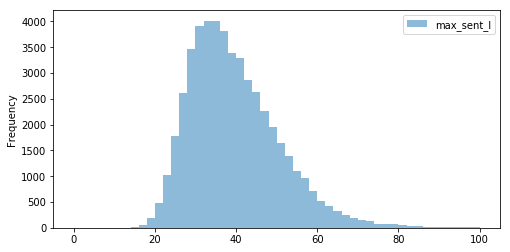

In [465]:
raw_train_df.plot(y=['max_sent_l'], bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 100));

In [466]:
np.sum(raw_train_df['max_sent_l'] <= 60) / len(raw_train_df)

0.95598

In [467]:
len(train_df)/len(raw_train_df), len(valid_df)/len(raw_valid_df), len(test_df)/len(raw_test_df)

(0.53656, 0.5434782608695652, 0.5703703703703704)

# build vocab for language modeling 

In [468]:
def get_word_cnt_dict(train_df, min_tf=None):
    # create vocab of words
    word_cnt_dict = defaultdict(int)
    word_cnt_dict['.'] = np.inf
    word_cnt_dict[EOS] = np.inf
    word_cnt_dict[BOS] = np.inf
    word_cnt_dict[UNK] = np.inf
    word_cnt_dict[PAD] = np.inf
    
    tokens_list = []
    for doc in train_df.tokens:
        tokens_list.extend(doc)
    
    for tokens in tokens_list:
        for word in tokens:
            word_cnt_dict[word] += 1
    word_cnt_dict = sorted(word_cnt_dict.items(), key=lambda x: x[1])[::-1]
    
    if type(min_tf) is int:
        word_cnt_dict = list(filter(lambda x: x[1] >= min_tf, word_cnt_dict))
    elif type(min_tf) is float:
        word_cnt_dict = word_cnt_dict[:int(min_tf*len(word_cnt_dict))]
    return word_cnt_dict

In [469]:
word_cnt_dict = get_word_cnt_dict(train_df, min_tf=5)
print(len(word_cnt_dict), len(get_word_cnt_dict(train_df, min_tf=0)))

20946 62461


In [470]:
idx_to_word = {idx: word for idx, (word, cnt) in enumerate(word_cnt_dict)}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}

# build bow vector

In [471]:
stop_word_cnt_dict = get_word_cnt_dict(train_df, min_tf=0.001)
len(stop_word_cnt_dict)

62

In [472]:
with open(config.stopwords_path, 'r') as f:
    stop_words_mallet = [w.replace('\n', '') for w in f.readlines()]
len(stop_words_mallet)

524

In [473]:
stop_words = stop_words_mallet + [w_cnt[0] for w_cnt in stop_word_cnt_dict if w_cnt[0] not in dummy_tokens]
len(stop_words)

582

In [474]:
train_corpus = list(train_df.doc)
valid_corpus = list(valid_df.doc)
test_corpus = list(test_df.doc)

In [475]:
vectorizer = TfidfVectorizer(min_df=100, max_df=1.0, stop_words=stop_words, tokenizer=word_tokenize, norm=None, use_idf=False, dtype=np.float32)
train_bow_list = vectorizer.fit_transform(train_corpus)
bow_tokens = vectorizer.get_feature_names()
print(len(bow_tokens))
assert len(train_df) == len(train_bow_list.toarray())
assert all([word in word_to_idx for word in bow_tokens])

2498


In [476]:
valid_bow_list = vectorizer.transform(valid_corpus)
test_bow_list = vectorizer.transform(test_corpus)

In [477]:
bow_idxs = np.array([word_to_idx[token] for token in bow_tokens])

## check

In [478]:
sample_doc_idx = 1
sample_doc = train_corpus[sample_doc_idx]
sample_tokens = word_tokenize(sample_doc)
filtered_tokens = [w for w in sample_tokens if (w not in vectorizer.stop_words_) and (w not in stop_words)]
assert all([word in bow_tokens for word in filtered_tokens])

filtered_word_cnt_dict = Counter(filtered_tokens)
pseudo_bow = np.array([float(filtered_word_cnt_dict[w]) if w in filtered_word_cnt_dict else 0. for w in bow_tokens])
# pseudo_bow = pseudo_bow / np.sum(pseudo_bow)

sample_bow = train_bow_list.toarray()[sample_doc_idx]
np.max((sample_bow - pseudo_bow)**2)

0.0

In [479]:
np.where(pseudo_bow>0)

(array([  84,  232,  316,  381,  387,  456,  632,  659,  725,  735,  972,
         975, 1037, 1072, 1076, 1137, 1195, 1208, 1274, 1288, 1441, 1531,
        1532, 1536, 1771, 1872, 1880, 1999, 2015, 2031, 2035, 2036, 2121,
        2144, 2352, 2457, 2476]),)

In [480]:
np.where(sample_bow>0)

(array([  84,  232,  316,  381,  387,  456,  632,  659,  725,  735,  972,
         975, 1037, 1072, 1076, 1137, 1195, 1208, 1274, 1288, 1441, 1531,
        1532, 1536, 1771, 1872, 1880, 1999, 2015, 2031, 2035, 2036, 2121,
        2144, 2352, 2457, 2476]),)

# write out

In [483]:
def prepare_instances(data_df, word_to_idx, bow_list):
    instances = []
    bows = bow_list.toarray()
    assert len(bows) == len(data_df)
    for bow, (idx_doc, doc) in zip(bows, data_df.iterrows()):
        instance = Instance()
        instance.idx = idx_doc
        doc_token_idxs = []
        for sent_tokens in doc.tokens:
            sent_token_idxs = [word_to_idx[token] if token in word_to_idx else word_to_idx[UNK] for token in sent_tokens]
            doc_token_idxs.append(sent_token_idxs)            
        instance.token_idxs = doc_token_idxs
        instance.doc_l = doc.doc_l
        instance.max_sent_l = doc.max_sent_l
        instance.bow = bow
        instances.append(instance)
    return instances

In [484]:
instances_train = prepare_instances(train_df, word_to_idx, train_bow_list)
instances_valid = prepare_instances(valid_df, word_to_idx, valid_bow_list)
instances_test = prepare_instances(test_df, word_to_idx, test_bow_list)

In [485]:
print('saving preprocessed instances...')
cPickle.dump((instances_train, instances_valid, instances_test, word_to_idx, idx_to_word, bow_idxs),open(config.output_path,'wb'))

saving preprocessed instances...
